In [1]:
CUDA_INDEX = 3
NAME = 'Protein'

In [2]:
import sys
sys.path.insert(0, '../..')
sys.path.insert(0, '../../pyged/lib')

In [3]:
import os
import pickle
import random
import time

import IPython as ipy
import matplotlib.pyplot as plt
import numpy as np
import torch
torch.cuda.set_device(CUDA_INDEX)
torch.backends.cudnn.benchmark = True
import torch.optim
import torch_geometric as tg
import torch_geometric.data
from tqdm.auto import tqdm

from neuro import config, datasets, metrics, models, train, utils, viz
import pyged

from importlib import reload
reload(config)
reload(datasets)
reload(metrics)
reload(models)
reload(pyged)
reload(train)
reload(utils)
reload(viz)

<module 'neuro.viz' from '../../neuro/viz.py'>

In [4]:
preds = [
    ('NeuroGSim     ', torch.load(f'../preds/{NAME}-FS/outer_pred.pt', map_location='cpu')),
    ('NeuroGSim-NN  ', torch.load(f'../preds/{NAME}-FS/nn_outer_pred.pt', map_location='cpu')),
    ('NeuroGSim-Dual', torch.load(f'../preds/{NAME}-FS/dual_outer_pred.pt', map_location='cpu')),
    ('SimGNN        ', torch.as_tensor(np.load(f'../preds/{NAME}-FS/sg_outer_pred.npy'))),
    ('Branch        ', torch.load(f'../preds/{NAME}-FS/b_outer_pred.pt', map_location='cpu')),
    ('F2            ', torch.load(f'../preds/{NAME}-FS/f2_outer_pred.pt', map_location='cpu')),
]

In [5]:
outer_test_set = torch.load(f'../data/{NAME}/outer_test.pt', map_location='cpu')
queries, _, lb, ub = outer_test_set

In [6]:
def range_metrics(fn, lb, ub, preds, ylabel, title, percent=True):
    r = torch.arange(1, int(torch.max(lb).item()), 1)
    plt.figure()
    Ys = []
    for label, pred in preds:
        Y = fn(r, lb, ub, pred)
        viz.plot_summary(r, Y, show_std=False, label=label, lim=percent)
        Ys.append((Y, label))
    plt.legend()
    plt.xlabel('range')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

    for Y, label in Ys:
#         print(f'{label}', end='\n')
        Z = utils.nanmean(Y, dim=-1)
        for i in [1,5,10,15,20]:
            if percent:
                print(f'{Z[(i*Z.shape[0]//100+1)-1].item()*100:.2f}', end=' / ' if i != 20 else '\n')
            else:
                print(f'{Z[(i*Z.shape[0]//100+1)-1].item()*100:.2f}', end=' / ' if i != 20 else '\n')
#         print()

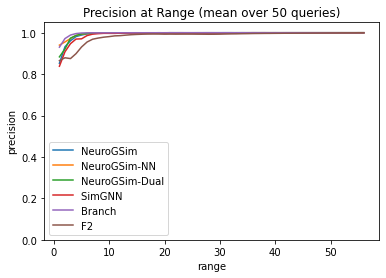

85.25 / 96.13 / 99.43 / 99.88 / 99.94
94.00 / 97.18 / 99.63 / 99.88 / 99.95
88.34 / 97.38 / 99.66 / 99.84 / 99.93
83.82 / 94.71 / 98.63 / 99.70 / 99.78
93.01 / 98.88 / 99.93 / 99.95 / 99.98
86.52 / 87.51 / 95.52 / 97.84 / 98.59


In [7]:
range_metrics(metrics.precision_at_range, lb, ub, preds,
              'precision', f'Precision at Range (mean over {len(queries)} queries)')

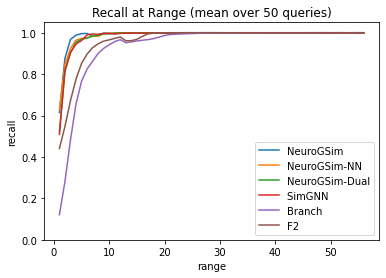

61.50 / 96.77 / 99.64 / 99.78 / 99.90
63.08 / 92.47 / 97.55 / 99.45 / 99.94
52.15 / 90.26 / 97.37 / 99.49 / 99.93
50.88 / 90.48 / 98.97 / 99.67 / 99.67
12.15 / 48.25 / 82.49 / 92.44 / 96.63
44.11 / 67.24 / 89.70 / 95.95 / 97.91


In [8]:
range_metrics(metrics.recall_at_range, lb, ub, preds,
              'recall', f'Recall at Range (mean over {len(queries)} queries)')

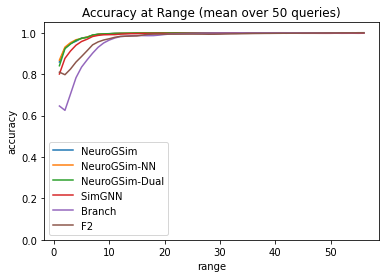

85.87 / 94.79 / 97.86 / 99.46 / 99.72
86.76 / 95.19 / 97.95 / 99.38 / 99.69
84.06 / 94.53 / 97.73 / 99.45 / 99.72
80.06 / 91.16 / 96.85 / 98.99 / 99.31
64.61 / 70.37 / 86.87 / 95.06 / 98.12
80.95 / 82.44 / 91.30 / 96.49 / 98.23


In [9]:
range_metrics(metrics.accuracy_at_range, lb, ub, preds,
              'accuracy', f'Accuracy at Range (mean over {len(queries)} queries)')

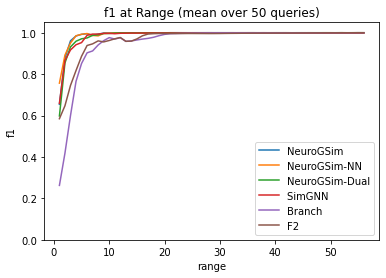

65.43 / 96.09 / 99.52 / 99.82 / 99.92
75.65 / 95.00 / 99.60 / 99.63 / 99.95
59.80 / 93.14 / 97.48 / 99.64 / 99.93
65.89 / 91.67 / 98.75 / 99.68 / 99.72
26.26 / 59.95 / 90.29 / 96.16 / 97.61
58.47 / 74.53 / 93.83 / 95.56 / 97.68


In [10]:
range_metrics(metrics.f1_at_range, lb, ub, preds,
              'f1', f'f1 at Range (mean over {len(queries)} queries)')

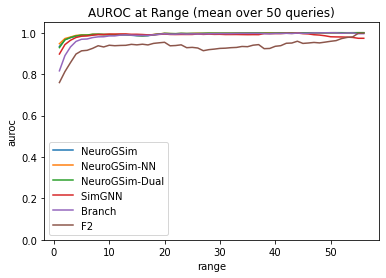

93.34 / 97.65 / 98.73 / 99.08 / 98.95
94.68 / 97.92 / 98.92 / 99.13 / 99.14
92.80 / 97.68 / 98.85 / 99.17 / 99.08
89.71 / 96.35 / 98.44 / 99.11 / 99.39
81.60 / 93.13 / 96.96 / 98.05 / 98.83
75.94 / 85.56 / 91.49 / 93.12 / 93.86


In [11]:
range_metrics(metrics.auroc_at_range, lb, ub, preds,
              'auroc', f'AUROC at Range (mean over {len(queries)} queries)')

# 